# Data processing

In this notebook, I am loading a list of molecules I obtained from ChEMBL and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [4]:
# Importing the necessary packages and specify the paths to relevant folders
import pandas as pd
from rdkit import RDLogger
import logging
from os import path, remove

# Disable warning messages
logging.getLogger("standardiser.standardise").setLevel(logging.ERROR)
RDLogger.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')

In [2]:
# Loading the data from the /data folder to a Pandas dataframe and understand which headers it has
data = pd.read_csv("../data/reference_library.csv")

In [3]:
data.head(5)

,smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...


In [4]:
# Converting the molecules to standard SMILES by using the function standardise_smiles from /src
import sys
sys.path.append('../src') 

from smiles_processing import standardise_smiles

data['standardise_smiles'] = data['smiles'].apply(standardise_smiles)
data = data.dropna(subset=['standardise_smiles'])

In [5]:
data.head(5)

,smiles,standardise_smiles
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1


In [6]:
# Getting the Inchikey representation of the molecules using the RDKIT package
from smiles_processing import smile_to_inchikey

data['inchi_key'] = data['standardise_smiles'].apply(smile_to_inchikey)
data = data.dropna(subset=['inchi_key'])

In [7]:
data.head(5)

,smiles,standardise_smiles,inchi_key
0,CCCCNC(=S)N/N=C/C1=C(C)C=CS1,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,CN1C(SCC2=NC(C3=CC=CS3)=NO2)=NN=C1C1CCCCC1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)C1=CN=CC=N1)C1=CC=CC=C1Cl,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(C1=CC=CC=C1)N1CCN(C2=NOC3=CC=CC(Cl)=C2...,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(C1=CC(Cl)=CC=C1CO)S(=O)(=O)C1=CC...,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N


In [8]:
# Saving the data as a .csv file containing only the standard smiles and the inchikey as columns. 
output_file = "../data/st_smile_inchikey.csv"

if path.exists(output_file):
    remove(output_file)

col = ['standardise_smiles', 'inchi_key']
updated_data = pd.DataFrame(data, columns=col)
updated_data.to_csv("../data/st_smile_inchikey.csv", index = False)

In [9]:
#Checking the data
df = pd.read_csv("../data/st_smile_inchikey.csv")
df.head(5)

,standardise_smiles,inchi_key
0,CCCCNC(=S)N/N=C/c1sccc1C,SUTWUYBMBWPLMW-MDWZMJQESA-N
1,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,RIYHJWOTNJXDLV-UHFFFAOYSA-N
2,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,OGNBARHGQVMGGX-UHFFFAOYSA-N
3,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,WQEXDIRUOYNDCM-UHFFFAOYSA-N
4,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,YEGVLLQDOGYWDQ-OAHLLOKOSA-N


# Model Bias Evaluation

Now, I will use the predictions I got from the Ersilia Model Hub on the dataset of 1000 molecules curated above and see how are they distributed in their space (which might be 0 to 1 for probabilities, or different for regression models)

In [16]:
# Loading the predictions ran on Ersilia from data saved in the /data folder
import time
from ersilia import ErsiliaModel

# Fetching and serving the model
model_name = "eos30gr" #deepherg
start = time.time()
mdl = ErsiliaModel(model_name)
end = time.time()
print("Model fetched. Time taken:", end - start)

Requested model eos30gr is not available locally. Do you want to fetch it? [Y/n]


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


[]


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


🚀 Serving model eos30gr: deepherg

   URL: http://127.0.0.1:35341
   PID: 43098
   SRV: conda

👉 To run model:
   - run

💁 Information:
   - info


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


⛔ Model eos30gr closed
Model fetched. Time taken: 146.35254907608032


In [17]:
# Running the predictions

mdl.serve()
start = time.time()
st_smiles = list(data['standardise_smiles'])
output = mdl.run(st_smiles, output = "pandas")
end = time.time()
print("Predictions calculated. Time taken:", end - start)
mdl.close()

sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit
sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


Predictions calculated. Time taken: 1068.2504601478577


sudo: unknown user udockerusername
sudo: error initializing audit plugin sudoers_audit


In [39]:
output.to_csv("../data/output_eos30gr.csv", index=False)
output.head(5)

,key,input,activity10
0,SUTWUYBMBWPLMW-MDWZMJQESA-N,CCCCNC(=S)N/N=C/c1sccc1C,0.347112
1,RIYHJWOTNJXDLV-UHFFFAOYSA-N,Cn1c(SCc2nc(-c3cccs3)no2)nnc1C1CCCCC1,0.547030
2,OGNBARHGQVMGGX-UHFFFAOYSA-N,O=C(O)CC(NC(=O)c1cnccn1)c1ccccc1Cl,0.178218
3,WQEXDIRUOYNDCM-UHFFFAOYSA-N,O=S(=O)(c1ccccc1)N1CCN(c2noc3cccc(Cl)c23)CC1,0.620462
4,YEGVLLQDOGYWDQ-OAHLLOKOSA-N,CCC[C@@H](C)N(c1cc(Cl)ccc1CO)S(=O)(=O)c1ccc(C)cc1,0.623267


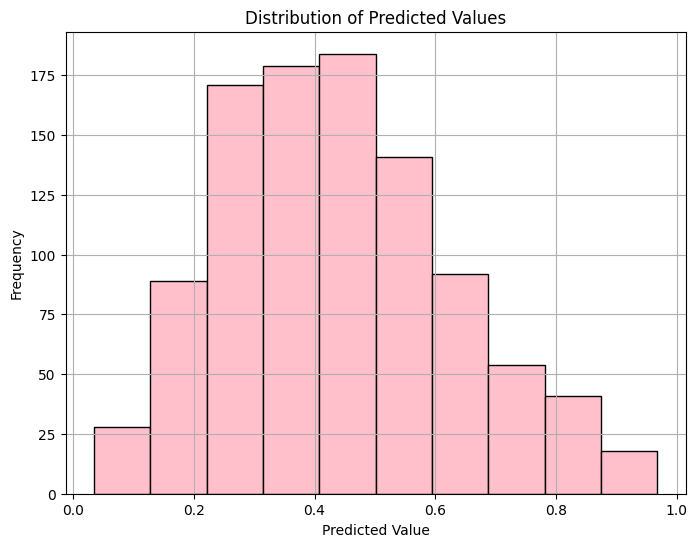

In [7]:
# Plots to observe the distribution of predicted values
import matplotlib.pyplot as plt

predicted_values = output['activity10']
# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(predicted_values, bins=10, color='pink', edgecolor='black')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('../plots/predicted_values_histogram.png')
plt.show()

From the above generated histogram, we see a relation between the number of compounds and their probability that they are a hERG blocker or not. The probabilities range from a value of 0 to 1. We notice that most of the compounds are concentrated in the range 0.25 - 0.60, indicating that majority of the compounds from our dataset has a probability of 25% - 60% of being a hERG blocker. About 28 compounds have low probability of being a hERG blocker and about 20 compounds have a high probability of being a hERG blocker.

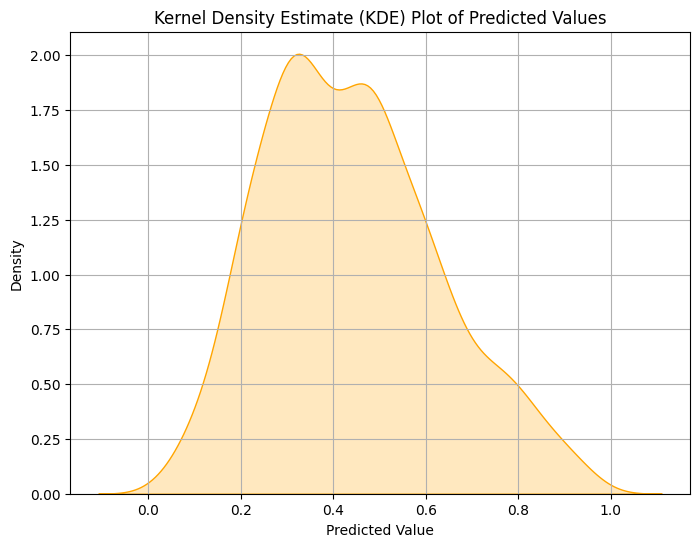

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(predicted_values, color='orange', fill=True)
plt.title('Kernel Density Estimate (KDE) Plot of Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.savefig('../plots/predicted_values_kde.png')
plt.grid(True)
plt.show()

The above Kernel Density Estimate (KDE) Plot is a graph of the PDF, that is the Probability Density Function. We can see the similar result as we saw from the histogram. The compounds which have are in the range 0.25 - 0.6 have maximum density that is, most of the compounds have a 25% - 60% chance of being a hERG blocker.